In [1]:
import os
import json 

# Data Visualization


In [2]:
with open('./valid/_annotations.coco.json','r') as file:
    data = json.load(file)

for img in data['images'][:10]:
    print(img['file_name'])

1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg
2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg
1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg
2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg
2647_jpg.rf.5ba404374f2d670f04a2d1367c77c039.jpg
1511_jpg.rf.5c02bb67a267960293c9e8393c2d9380.jpg
1018_jpg.rf.5c6fcb4480745ff7c60c7305781913ab.jpg
1694_jpg.rf.5c8d647ce366cbd41426af5217863bd4.jpg
2824_jpg.rf.5ca7452639b345dfd0206a58531b6910.jpg


In [3]:
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [4]:
#To see the structure of the json file 
def print_structure (d, indent=0):
    if isinstance(d,dict):
        for key , value in d.items():
            print(' ' * indent + str(key))
            print_structure(value,indent+1)
    elif isinstance(d, list):
        print(' ' * indent + "list of length {} containing : ".format(len(d)))
        if d:
            print_structure(d[0],indent+1) # only print the structure of the first item

with open('./valid/_annotations.coco.json','r') as file:
    data = json.load(file)

In [5]:
print_structure(data)

info
 year
 version
 description
 contributor
 url
 date_created
licenses
 list of length 1 containing : 
  id
  url
  name
categories
 list of length 3 containing : 
  id
  name
  supercategory
images
 list of length 429 containing : 
  id
  license
  file_name
  height
  width
  date_captured
annotations
 list of length 429 containing : 
  id
  image_id
  category_id
  bbox
   list of length 4 containing : 
  area
  segmentation
   list of length 1 containing : 
    list of length 10 containing : 
  iscrowd


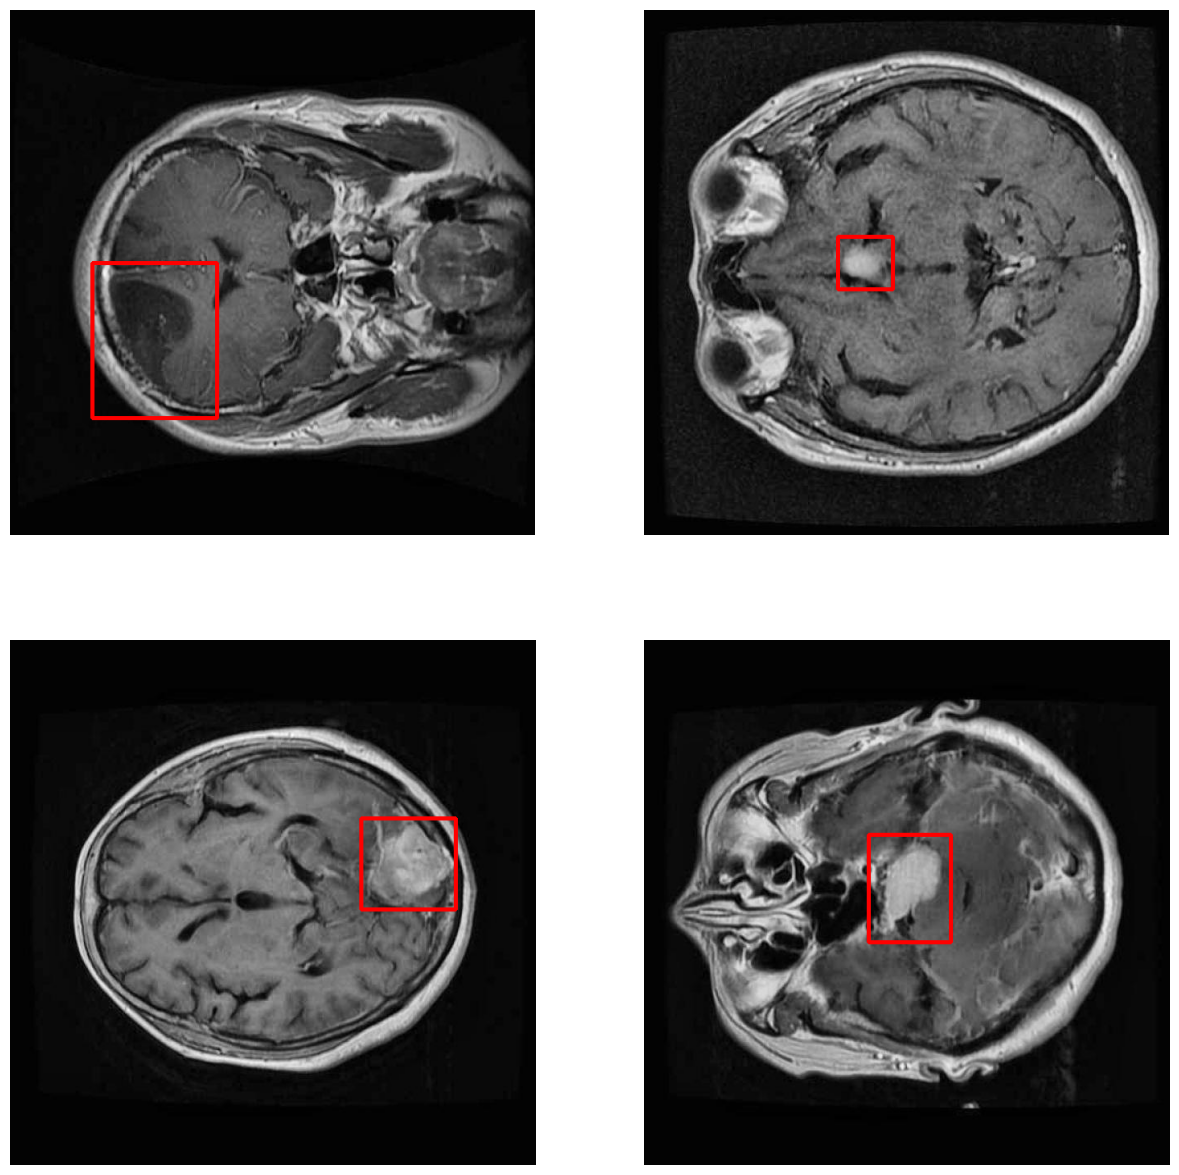

In [6]:

import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import numpy as np
import random 

def display_masks(image_names, data):
    fig , ax = plt.subplots(2,2,figsize = (15,15))
    for i, img_path in enumerate(image_names):
        draw_image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        points_list = img_annotations[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1,1,2))
        # Draw polygon
        cv2.polylines(draw_image,[points],True,(0,0,255),3)
        
        # Display the image
        ax[i//2, i%2].imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

        
#Loading the data for visualization part
with open('./valid/_annotations.coco.json','r') as file:
    annotations = json.load(file)
#get all the image files
imge_dir = "./valid"
all_image_files = [os.path.join(imge_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files,4)
#call the draw mask function
display_masks(random_image_files,annotations)

In [7]:
#Function to create binary mask out from the json format
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    object_number = 1
    printed_masks = 0  # Counter for the number of printed masks
    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            for seg_idx, seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                # Create a mask for each segmentation
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  # Set the pixel values to 255 for the polygon
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached

In [8]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)

In [9]:
original_image_dir = './test'  # Where your original images are stored
json_file = './test/_annotations.coco.json'
mask_output_folder = './working/test2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = './working/test2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = './train'  # Where your original images are stored
json_file = './train/_annotations.coco.json'
mask_output_folder = './working/train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = './working/train2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = './valid'  # Where your original images are stored
json_file = './valid/_annotations.coco.json'
mask_output_folder = './working/valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = './working/valid2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)


In [10]:
def compare_folders_and_delete(folder1_path, folder2_path):
    folder1_items = os.listdir(folder1_path)
    folder2_items = os.listdir(folder2_path)

    for item1 in folder1_items:
        found = False
        for item2 in folder2_items:
            if item1[:4] == item2[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1_path, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    for item2 in folder2_items:
        found = False
        for item1 in folder1_items:
            if item2[:4] == item1[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2_path, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")

# Example usage:
folder1_path = "./working/train2/images"
folder2_path = "./working/train2/masks"
compare_folders_and_delete(folder1_path, folder2_path)

Corresponding item for 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


# Custom Dataset creation

In [11]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "./working/train2" 
valid_path = "./working/valid2"
test_path = "./working/test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Create datasets
train_dataset = CustomDataset_general(train_path, transform=image_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform)
test_dataset = CustomDataset_general(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([32, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [ ]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset ,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler